<a href="https://colab.research.google.com/github/Enkhamgalan1230/ML-projects/blob/main/spamDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import string
import nltk
#A lot of the data that you could be analyzing is unstructured data and contains human-readable text.
#Before you can analyze that data programmatically, you first need to preprocess it
from nltk.corpus import stopwords
# Stop words are like 'the, a, an, etc'
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
#Tokenizer from TensorFlow provides a convenient way to preprocess text data for
#machine learning tasks by converting text into numerical representations that can be fed into neural networks or other machine learning models.
from tensorflow.keras.preprocessing.text import Tokenizer
#Preparing sequence data for machine learning tasks, ensuring uniformity in sequence lengths across the dataset.
from tensorflow.keras.preprocessing.sequence import pad_sequences
#function for splitting a dataset into training and testing subsets
from sklearn.model_selection import train_test_split

#EarlyStopping is a callback that helps prevent overfitting by stopping the training process when the model's performance on a validation dataset begins to degrade.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#telling Python to suppress any warning messages that may occur during the execution of your script.
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Padding and truncating are techniques used to adjust the length of sequences to make them uniform when dealing with variable-length data, such as text sequences in natural language processing. These techniques are commonly used in machine learning and deep learning tasks where input data needs to be of consistent size.

Padding:

Padding involves adding extra tokens or values to the sequences to make them all the same length.
It is typically done by appending special tokens (e.g., zeros) to the beginning or end of shorter sequences until they reach a predefined length.
Padding ensures that all sequences in the dataset have the same length, which is often required for processing in neural networks and other machine learning algorithms.
Padding is crucial for tasks like text classification or sentiment analysis, where inputs must have consistent dimensions.

Truncating:

Truncating involves removing tokens or values from sequences that exceed a specified maximum length.
It is performed to ensure that all sequences in the dataset are within a predefined length limit.
Truncation can occur at the beginning or end of the sequence, depending on the application and requirements.
Truncating is often necessary when dealing with sequences longer than the desired maximum length to prevent memory overflow or computational inefficiency.

In [39]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.6.6-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.6
    Uninstalling kaggle-1.6.6:
      Successfully uninstalled kaggle-1.6.6


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [34]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/

In [35]:
! chmod 600 ~/.kaggle/kaggle.json

In [36]:
#! kaggle datasets list

In [84]:
#!kaggle datasets download -d uciml/sms-spam-collection-dataset
!kaggle datasets download -d jackksoncsie/spam-email-dataset

  0% 0.00/2.86M [00:00<?, ?B/s]
100% 2.86M/2.86M [00:00<00:00, 138MB/s]


In [85]:
!unzip spam-email-dataset.zip

Archive:  spam-email-dataset.zip
  inflating: emails.csv              


In [86]:
data = pd.read_csv('emails.csv',encoding='latin-1')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [87]:
data.shape

(5728, 2)

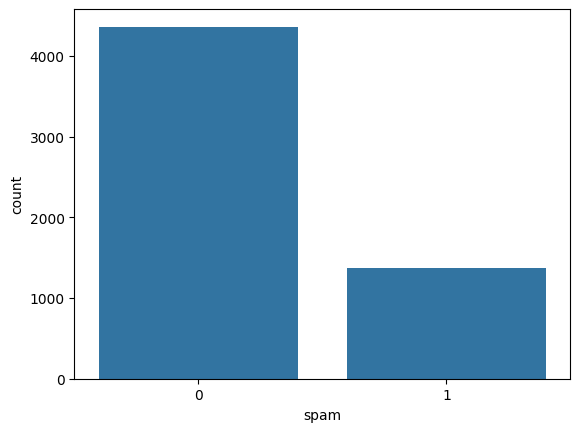

In [89]:
#ratio of spam and normal msg in dataset,
sns.countplot(x = 'spam', data=data )
plt.show()

Text(0.5, 0, 'Message types')

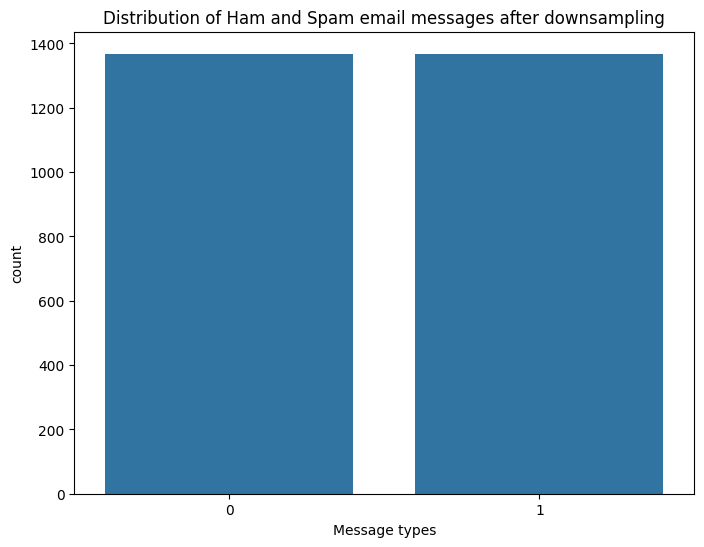

In [93]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [94]:
#'spam = v1 text =v2'

balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [96]:
#This removes punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [97]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


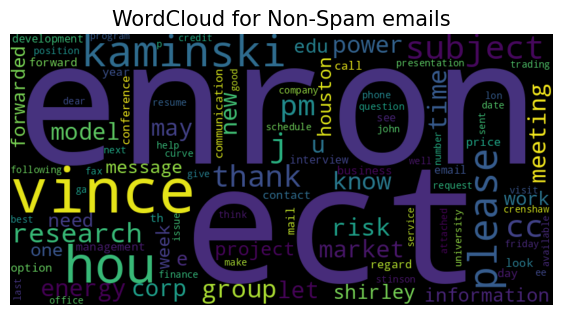

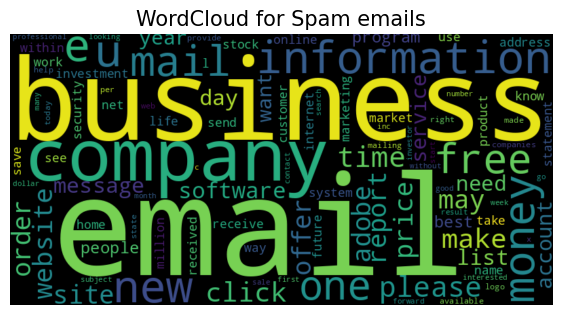

In [98]:
 def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


We cannot feed words to a machine learning model because they work on numbers only. So, first, we will convert our words to vectors with the token IDs to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.

In [99]:
# It splits the data to training part and testing part and test size represents the ratio
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42) # This parameter sets the random seed for reproducibility.
                                                                       # It ensures that the split will be the same every time you run the code with the same random state.

In [100]:
 # Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [101]:
 # Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           805024    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [105]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

 It's not necessary to reach the specified number of epochs if the model has already converged and is performing well on the validation dataset.

In [106]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
69/69 [==============================] - 10s 75ms/step - loss: 0.6222 - accuracy: 0.6696 - val_loss: 0.3489 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 3s 45ms/step - loss: 0.1673 - accuracy: 0.9671 - val_loss: 0.1306 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 3s 48ms/step - loss: 0.1520 - accuracy: 0.9616 - val_loss: 0.1788 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 5s 66ms/step - loss: 0.1294 - accuracy: 0.9726 - val_loss: 0.1422 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0625 - accuracy: 0.9890 - val_loss: 0.1611 - val_accuracy: 0.9635 - lr: 5.0000e-04


In [107]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 9ms/step - loss: 0.1306 - accuracy: 0.9690
Test Loss : 0.13061636686325073
Test Accuracy : 0.9689781069755554


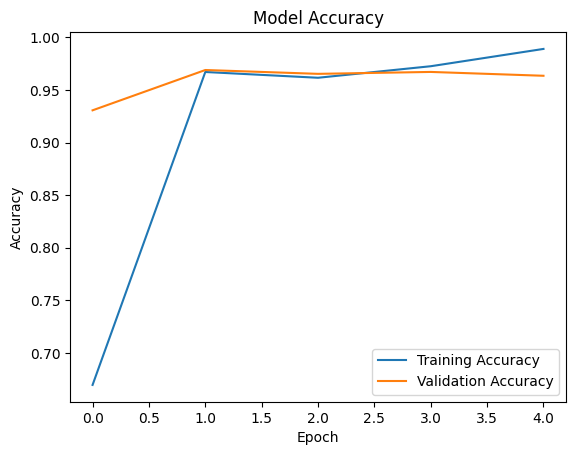

In [108]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#test commit123